In [ ]:
#CSE 145 - DeadReckoning attempt

In [136]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz
from scipy import integrate

import os
os.environ['PROJ_LIB'] = r'C:\Users\QM\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

import mpld3
import folium
#import cmocean
import skinematics as skin
from skinematics import quat, vector, misc, rotmat, imus, view
import pygame

from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added

# For the definition of the abstract base class IMU_Base
import abc
import sys
import requests

# google maps for dead-reckoning
import googlemaps
from gmplot import gmplot
from datetime import datetime

# %matplotlib notebook
%matplotlib inline
print("done")

done


# Fetch data 

In [137]:
ride_ids = ['15218']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29)

In [138]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            #print(ocean_df_small)
            
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
    
print("done loading data")

done loading data


In [139]:
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])

##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.
#print(motion_df)
print("done importing data")


https://surf.smartfin.org/ride/15218
https://surf.smartfin.org/media/201808/google_105349665704999793400_0006667E229D_180829164842_Ocean.CSV
Ride data has been uploaded.
done importing data


# Create dataframes, Clean and Organize data

In [140]:
saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data

#Reading data from ride_ids = ['xxxxx']
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Drop the "nan" values from the columns that we care about. 
dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 
                                            'IMU M2', 'IMU M3'])
#Can test that this works by printing this one:
#dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'Latitude'])
#print(dropped_df)

time_e_list = []
time_o_list = []

#Remove all nan instances in time:
time_array_nans = np.array(dropped_motion_df.loc[:,"Time"], dtype=float)
time_array = []
imuA1_array_nans = np.array(dropped_motion_df.loc[:,"IMU A1"], dtype=float)
imu_array_A1 = []
imuA2_array_nans = np.array(dropped_motion_df.loc[:,"IMU A2"], dtype=float)
imu_array_A2 = []
imuA3_array_nans = np.array(dropped_motion_df.loc[:,"IMU A3"], dtype=float)
imu_array_A3 = []
imuG1_array_nans = np.array(dropped_motion_df.loc[:,"IMU G1"], dtype=float)
imu_array_G1 = []
imuG2_array_nans = np.array(dropped_motion_df.loc[:,"IMU G2"], dtype=float)
imu_array_G2 = []
imuG3_array_nans = np.array(dropped_motion_df.loc[:,"IMU G3"], dtype=float)
imu_array_G3 = []
imuM1_array_nans = np.array(dropped_motion_df.loc[:,"IMU M1"], dtype=float)
imu_array_M1 = []
imuM2_array_nans = np.array(dropped_motion_df.loc[:,"IMU M2"], dtype=float)
imu_array_M2 = []
imuM3_array_nans = np.array(dropped_motion_df.loc[:,"IMU M3"], dtype=float)
imu_array_M3 = []

#Get all the times and imus where time, imu a1, imu a2, and imu a3 are NOT nan values:
for t,x,y,z,a,b,c,d,e,f in zip(time_array_nans, imuA1_array_nans, imuA2_array_nans, imuA3_array_nans, imuG1_array_nans, 
                              imuG2_array_nans, imuG3_array_nans, imuM1_array_nans, imuM2_array_nans, imuM3_array_nans):
    if (np.isnan(t)==0 and np.isnan(x)==0 and np.isnan(y)==0 and np.isnan(z)==0):
        time_array.append(t)
        imu_array_A1.append(x)
        imu_array_A2.append(y)
        imu_array_A3.append(z)
        imu_array_G1.append(a)
        imu_array_G2.append(b)
        imu_array_G3.append(c)
        imu_array_M1.append(d)
        imu_array_M2.append(e)
        imu_array_M3.append(f)

#for x in time_array:
#    print(x)

time_current = []
    
time_current.append(time_array[0])
start_time = time_array[0]
time_len = len(time_array)
    
i = 0
while (i < time_len - 1):
    prev = time_array[i]
    after = time_array[i+1]
    offset = after - prev
    #if (np.isnan(offset)==0):
    time_o_list.append(offset)
    
    elapsed = time_array[i] - start_time
    #if (np.isnan(elapsed)==0):
    time_e_list.append(elapsed)
    time_current.append(time_array[i])
    
    i = i + 1

##Check to make sure there are no "nan" values:
i = 0
while (i < len(time_o_list)):
    if (np.isnan(time_o_list[i])):
        print("Error! Value at index: ", i, " is nan")
    i = i + 1

#Drop the last value from each of the imu lists to make it match the time list.
del(imu_array_A1[-1])
del(imu_array_A2[-1])
del(imu_array_A3[-1])
del(imu_array_G1[-1])
del(imu_array_G2[-1])
del(imu_array_G3[-1])
del(imu_array_M1[-1])
del(imu_array_M2[-1])
del(imu_array_M3[-1])
del(time_current[-1])
print("Done.")

Done.


In [141]:
## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])
#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512
gyro_const = 8.2      # Raw gyrscope constant 8.2 bits per degree

gravity = 9.80665     # Approximate measurement for gravity

# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2

def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??) --> Not yet, we'll do it later on
        new_a = a / g_const * gravity# - gravity
        ret_array.append(new_a)
    return ret_array

imuA1_array = convert_acc_units(imu_array_A1) #new units in m/s^2
imuA2_array = convert_acc_units(imu_array_A2) #new units in m/s^2
imuA3_array = convert_acc_units(imu_array_A3) #new units in m/s^2

##To check:
#for x,y in zip(imuA2_array, imu_array_A2):
    #print(x,y)
    
def convert_gyr_units(gyr_array):
    ret_array = []
    for g in gyr_array:
        # Gyroscopic Rotation converts to deg/s
        new_g = g / gyro_const
        ret_array.append(new_g)
    return ret_array

imuG1_array_not_cal = convert_gyr_units(imu_array_G1) #new units in deg/s (will need to be rads for some later functions)
imuG2_array_not_cal = convert_gyr_units(imu_array_G2)
imuG3_array_not_cal = convert_gyr_units(imu_array_G3)

#To check:
#for x,y in zip(imuG2_array, imu_array_G2):
    #print(x,y)
    
    
def convert_time_units(time_array):
    ret_array = []
    for t in time_array:
        new_t = t * (10**(-3)) #converting units in milliseconds to seconds
        ret_array.append(new_t)
    return ret_array

time_o_array = convert_time_units(time_o_list) #new units in seconds
time_e_array = convert_time_units(time_e_list) #new units in seconds

print("Done.")

Done.


# Calibrate gyroscope and generate Rotation matrix

In [142]:
def adaptive_gyroscope_calibration(gyr, thresh):
    # Takes in gyroscope array [1xN] and a threshold value in deg/s
    print("The current threshold value is:",thresh)       # Prints the threshold
    ret_array = gyr.copy()                            # Initialize the calibrated return array (which will be calibrated and returned)
    calibration_constant = 0                              # Initialize loop variables
    last_touched_value = 0
    calibration_was_attempted = 0
    current = 0
    #calibrations_completed = 0
    calarray_pos = np.zeros(shape=(500,1))                  #Initialize an array to store calibration constant positions in (made excessively large for longer sessions)
    calarray_constants = np.zeros(shape=(500,1))            #Initialize an array to store calibration constant values
    print("Total rows of data:", len(gyr))
    
    calibration_was_attempted = 0     # Reset all state variables
    last_touched_value = 0
    calibrations_completed = 0
    current = 0                       # Reset iterator
    while current < len(gyr) - 100:
    #for current in range(len(gyr)):
        calibration_was_attempted = 0                 #Reset the state of calibration attempted
        curr_pos = gyr[current]
        next_pos = gyr[current+1]
        difference = next_pos - curr_pos          #Find the delta between current and next value
        
        if (difference < thresh) and (difference > -1*thresh):   #If the delta is within the threshold:
            calibration_was_attempted = 1                        #Change state: calibration_was_attempted to true
            start_average = current                              #Mark the start of a potential averaging window
            end_average = current+1                              #Initialize the end of a potential averaging window (size 1 to be safe)
            next_seven_fail = 0                                  #Initialize variable to tell if next 7 deltas were within threshold
            end_of_deltas = 0                                    #Initialize variable to tell when delta is no longer within threshold
            final_sev_check_pos = 0                              #Initialize variable to hold marker at the last seven check position
           
            for seven_check in range(7):                                       # Check the next 7 deltas (1/4 second @ 30Hz) to get min window
                sev_check_curr_pos = gyr[current+seven_check+1]
                sev_check_next_pos = gyr[current+seven_check+2]
                sev_check_difference = sev_check_next_pos - sev_check_curr_pos
                if (sev_check_difference > thresh) or (sev_check_difference < -1*thresh):  # If at any point a delta is not within threshold, then stop and start over
                    next_seven_fail = 1                         #Change failure status of seven_check to TRUE
                    final_sev_check_pos = current+seven_check+1
                    last_touched_value = current+seven_check+1  #Update the last_touched_value by the loop
                    break                                       #Break out of the loop and restart
                final_sev_check_pos = current+seven_check+1     #Update the last position in seven_check
                end_average = final_sev_check_pos               #Update the end of the averaging window
                last_touched_value = end_average                #Update the last touched value
            
            if next_seven_fail == 0:                      #If the next seven deltas are within threshold, continue looking for last valid delta (if seven_check failed, then this loop shouldn't run)
                iterator = 0
                while (end_of_deltas == 0) and (not (gyr[final_sev_check_pos+iterator] is None)):
                    #while we haven't found the last valid delta, AND the next value isn't empty/DNE
                    if final_sev_check_pos+iterator+1 >= len(gyr):
                        end_of_deltas = 1
                        end_average = final_sev_check_pos+iterator
                        last_touched_value = end_average
                    else:
                        finding_end_curr_pos = gyr[final_sev_check_pos+iterator]
                        finding_end_next_pos = gyr[final_sev_check_pos+iterator+1]
                        finding_end_difference = finding_end_next_pos - finding_end_curr_pos
                        if (finding_end_difference >= thresh) or (finding_end_difference <= -1*thresh):      #if difference is outside threshold, enter "end found" state
                            end_of_deltas = 1                                     #Set "end found" state to true
                            end_average = final_sev_check_pos+iterator            #Mark ending of window with the last valid delta position
                            last_touched_value = end_average                      #Update the last touched value
                            break
                        iterator += 1
                averaging_pos = start_average
                total_sum = 0
                num_of_nums = 0
                while (averaging_pos < end_average) and (averaging_pos < len(gyr)-1):	#Start averaging the values within the averaging window
                    total_sum += gyr[averaging_pos]
                    num_of_nums += 1
                    averaging_pos += 1
                calibration_constant = total_sum / num_of_nums
                calarray_pos[calibrations_completed] = current #Store calibration start location into an array
                calarray_constants[calibrations_completed] = calibration_constant #Store calibrations into an array
                calibrations_completed += 1
                #print("Start of the average was",start_average)
                #print("Position of the last touched value was",last_touched_value)
                #print("Newest calibration calculated:",calibration_constant)
        if calibration_was_attempted == 1:
            current = last_touched_value     #Assign current to the last value looked at by the loop, to avoid redundant searches
        else:
            current += 1
    
    cal_pos_iterator = 0     # Iterator to point to next upcoming calibration position, so we know when to change calibration value
    for i in range(len(ret_array)):
        if cal_pos_iterator == 0:     # Unique case for setting the first calibration constant
            enforcer = calarray_constants[0]
            cal_pos_iterator = 1
            #cal_value_iterator = 1
            ret_array[i] -= enforcer
        else:
            if i < calarray_pos[cal_pos_iterator] and i < len(ret_array)-1:       # if the current position hasn't reached the start of the next calibration window
                ret_array[i] -= enforcer
            elif i == calarray_pos[cal_pos_iterator] and i < len(ret_array)-1:    # if the current position is at the start of the next calibration window
                enforcer = calarray_constants[cal_pos_iterator]
                cal_pos_iterator += 1
                ret_array[i] -= enforcer
            elif i > calarray_pos[cal_pos_iterator] and i < len(ret_array)-1 and calarray_pos[cal_pos_iterator] == 0:
                ret_array[i] -= enforcer
            else:
                print("Current position skipped unexpectedly past next calibration window.")
                print(i)
                break
    return ret_array


threshold = 5 / 8.2  # Set the threshold that passes to the calibration function
imuG1_array = adaptive_gyroscope_calibration(imuG1_array_not_cal, threshold)
imuG2_array = adaptive_gyroscope_calibration(imuG2_array_not_cal, threshold)
imuG3_array = adaptive_gyroscope_calibration(imuG3_array_not_cal, threshold)

G1_comparison = np.stack((imuG1_array_not_cal, imuG1_array), axis=-1)
print(G1_comparison)
print("Done calibrating.")


The current threshold value is: 0.6097560975609757
Total rows of data: 8348
Current position skipped unexpectedly past next calibration window.
8347
The current threshold value is: 0.6097560975609757
Total rows of data: 8348
Current position skipped unexpectedly past next calibration window.
8347
The current threshold value is: 0.6097560975609757
Total rows of data: 8348
Current position skipped unexpectedly past next calibration window.
8347
[[2.439024390243903 array([1.49667406])]
 [0.0 array([-0.94235033])]
 [8.658536585365855 array([7.71618625])]
 ...
 [2.3170731707317076 array([1.33987963])]
 [-0.12195121951219513 array([-1.09914476])]
 [-0.9756097560975611 -0.9756097560975611]]
Done calibrating.


In [143]:
# Offset variables help in recentering the magnetic data in order to define direction and use trig functions
#     for some calculations. These values were estimated from data collected from multiple tests and hold fairly well.
# Magnetic data is relative, so as long as all of the axis share similar magnitude in value, then data should be fine
M1_offset_var = 219.786
M2_offset_var = 180
M3_offset_var = 280

def calibrate_magn_data(magn_array, offset_value):
    ret_array = []
    for m in magn_array:
        new_m = m - offset_value
        ret_array.append(new_m)
    return ret_array

imuM1_array = calibrate_magn_data(imu_array_M1, M1_offset_var)
imuM2_array = calibrate_magn_data(imu_array_M2, M2_offset_var)
imuM3_array = calibrate_magn_data(imu_array_M3, M3_offset_var)

print("Done.")

Done.


In [144]:
# Create N x 3 arrays for functions that need them later on, such as Scikit Kinematics
acc_height = len(imuA1_array)
gyr_height = len(imuG1_array)
magn_height = len(imuM1_array)

acc_array = np.zeros(shape=(acc_height,3))
gyr_array = np.zeros(shape=(gyr_height,3))
magn_array = np.zeros(shape=(magn_height,3))

for x in range(len(acc_array)):
    acc_array[x,0] = imuA1_array[x]
    acc_array[x,1] = imuA2_array[x]
    acc_array[x,2] = imuA3_array[x]


for x in range(len(gyr_array)):
    gyr_array[x,0] = imuG1_array[x]
    gyr_array[x,1] = imuG2_array[x]
    gyr_array[x,2] = imuG3_array[x]


for x in range(len(magn_array)):
    magn_array[x,0] = imuM1_array[x]
    magn_array[x,1] = imuM2_array[x]
    magn_array[x,2] = imuM3_array[x]

print("Done.")

Done.


In [145]:
# The new array for board reference frame will have the IMUs in columns according to X,Y,Z directions
board_acc = acc_array.copy()       # Reassign to the correct axes as stated above
temp_x_acc = board_acc[:,0] * (-1)
temp_y_acc = board_acc[:,2] * (-1)
temp_z_acc = board_acc[:,1] * (-1)
board_acc[:,0] = temp_x_acc     # X acceleration
board_acc[:,1] = temp_y_acc     # Y acceleration
board_acc[:,2] = temp_z_acc     # Z acceleration

#print('X              ', 'Y              ', 'Z')
#print(acc_array[:4,:])
#print(board_acc[:4,:])     # Display check to see if they are properly assigned
board_gyr = gyr_array.copy()
temp_x_gyr = board_gyr[:,0] * (-1)
temp_y_gyr = board_gyr[:,2] * (-1)
temp_z_gyr = board_gyr[:,1] * (-1)
board_gyr[:,0] = temp_x_gyr
board_gyr[:,1] = temp_y_gyr
board_gyr[:,2] = temp_z_gyr

board_magn = magn_array.copy()
temp_x_magn = board_magn[:,0] * (-1)
temp_y_magn = board_magn[:,2] * (-1)
temp_z_magn = board_magn[:,1] * (-1)
board_magn[:,0] = temp_x_magn
board_magn[:,1] = temp_y_magn
board_magn[:,2] = temp_z_magn
print("Done.")

Done.


In [146]:
print(board_acc)

[[  1.7238252   -1.91536133  -7.77636699]
 [  0.13407529  -1.62805713  -8.59997236]
 [  1.81959326  -1.8770541  -10.20887588]
 ...
 [  1.95366855   2.85388838   9.13627354]
 [  1.93451494   2.56658418   9.25119521]
 [  1.8770541    2.56658418   9.05965908]]


In [147]:
import numpy as np
from sklearn import preprocessing
import math

board_acc_norms = preprocessing.normalize(board_acc, norm='l2')
board_magn_norms = preprocessing.normalize(board_magn, norm='l2')

#print(board_acc[0])
#print(board_acc_norms[0])
gravity_vec = board_acc_norms[0]
entry_1_1 = (math.pow(gravity_vec[1], 2) - (math.pow(gravity_vec[0], 2) * gravity_vec[2]))
entry_1_1 /= (math.pow(gravity_vec[0], 2) + math.pow(gravity_vec[1], 2))
entry_2_1 = (-(gravity_vec[0] * gravity_vec[1]) - (gravity_vec[0] * gravity_vec[1] * gravity_vec[2]))
entry_2_1 /= (math.pow(gravity_vec[0], 2) + math.pow(gravity_vec[1], 2))
entry_3_1 = -gravity_vec[0]
first_column = np.array([entry_1_1, entry_2_1, entry_3_1])
entry_1_2 = entry_2_1
entry_2_2 = (math.pow(gravity_vec[0], 2) - (math.pow(gravity_vec[1], 2) * gravity_vec[2]))
entry_2_2 /= (math.pow(gravity_vec[0], 2) + math.pow(gravity_vec[1], 2))
entry_3_2 = -gravity_vec[1]
second_column = np.array([entry_2_1, entry_2_2, entry_3_2])
third_column = np.array([gravity_vec[0], gravity_vec[1], -gravity_vec[2]])
rotation_matrix = np.column_stack((first_column, second_column, third_column))
gravity_as_np = np.array(gravity_vec)
gravity_after_rotation = np.matmul(rotation_matrix, np.transpose(gravity_as_np))
print(gravity_after_rotation)

ent_1_1 = 1 / (math.sqrt(1 + (math.pow(gravity_vec[1], 2) / math.pow(gravity_vec[0], 2))))
ent_2_1 = gravity_vec[1] / (gravity_vec[0] * (math.sqrt(1 + (math.pow(gravity_vec[1], 2) / math.pow(gravity_vec[0], 2)))))
first_col = np.array([ent_1_1, ent_2_1, 0])
ent_1_2 = -ent_2_1
ent_2_2 = ent_1_1
second_col = np.array([ent_1_2, ent_2_2, 0])
third_col = np.array([0, 0, 1])
rot_matrix = np.column_stack((first_col, second_col, third_col))

actual_ro_mat = rotation_matrix * rot_matrix

board_acc_rotation = board_acc.copy()
for x in range(len(board_acc_rotation)):
    board_acc_rotation[x] = np.matmul(actual_ro_mat, np.transpose(board_acc_rotation[x]))
    
board_magn_rotation = board_magn.copy()
for x in range(len(board_magn_rotation)):
    board_magn_rotation[x] = np.matmul(actual_ro_mat, np.transpose(board_magn_rotation[x]))
#print(board_acc_norms)
#print(board_magn_norms)
#north_vec = board_magn_norms[0]
#down_vec = board_acc_norms[0]
#east_vec = np.cross(down_vec, north_vec)
#rotation_matrix = np.column_stack((north_vec, east_vec, down_vec))
#print(rotation_matrix)
#rotation_matrix = np.transpose(rotation_matrix)
print(rotation_matrix)
print("Done.")

[-2.77555756e-17  2.77555756e-17 -1.00000000e+00]
[[ 0.9772846   0.02523933  0.21042286]
 [ 0.02523933  0.9719563  -0.23380318]
 [-0.21042286  0.23380318  0.9492409 ]]
Done.


In [148]:
# Calculate the delta quaternions relative to the Earth's magnetic reference frame from the rate, accelerometer, gyro,
#     and magnetic data. All functions automatically iterate through arrays unless specified otherwise
rate = 33 # Frequency of data polling in Hz
board_gyr_rad = board_gyr * np.pi/180     # Converting from degrees to radians for the kalman function to create quaternions
delta_quats = imus.kalman(rate,board_acc_rotation,board_gyr_rad,board_magn_rotation)
#print(len(delta_quats))
#print(delta_quats)
print("Kalman quaternions finished.")

#init_rotated_quats = quat.q_mult(Q_init_pos, delta_quats) # Using delta_quats instead of vector quats to avoid unit length
#print(init_rotated_quats, "\n")

#init_rotated_quats2 = quat.q_mult(delta_vectors, Q_init_pos)
#print(init_rotated_quats2)
print("Initial orientation quaternion applied to Kalman quats.")

#final_orient_quats = quat.q_mult(Q_mag2lff, init_rotated_quats)
#print(final_orient_quats) # Still delta quaternions, not absolute position/angles
print("Magnetic to LFF quaternion applied to other quats.")

print(delta_quats)
print("Done.")

Kalman quaternions finished.
Initial orientation quaternion applied to Kalman quats.
Magnetic to LFF quaternion applied to other quats.
[[ 1.          0.          0.          0.        ]
 [ 0.99802292  0.00704416  0.01551049  0.06049835]
 [ 0.99142133 -0.06104254 -0.019155    0.11397652]
 ...
 [ 0.38063888 -0.05383036 -0.86963528  0.30975929]
 [ 0.38034875 -0.04446918 -0.8646936   0.32505739]
 [ 0.35966896 -0.05361017 -0.87217264  0.3272294 ]]
Done.


# Change coordinate frames, double integrate acceleration, and map coordinates (dead-reckoning)

In [149]:
accX_ECEF = []
accY_ECEF = []

for i in range(len(board_acc_rotation)):
    accX_ECEF.append(board_acc_rotation[i][0])
    accY_ECEF.append(board_acc_rotation[i][1])

In [150]:
R_Earth_m = 6378.137 * 1000

def change_latitude(metersX):
    return (metersX/R_Earth_m) * 180.0/math.pi

def change_longitude(latitude, metersY):
    r = R_Earth_m*math.cos(latitude*(math.pi/180.0))
    return (metersY/r)*180.0/math.pi

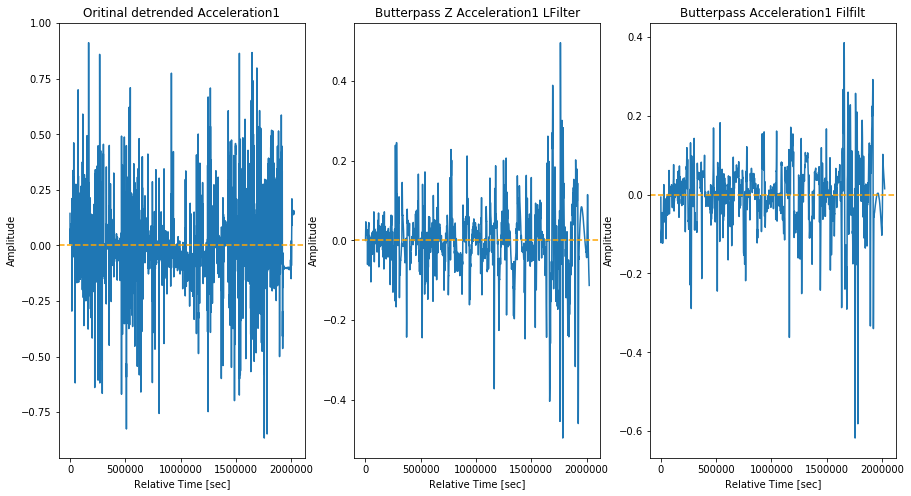

In [151]:
## Butter Filters for Bandpass:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

# Define the sample rate and the Low and High Cutoff frequencies
fs = 30
lowcut = 0.0333
highcut = 1.5

##Graphing the bandpass filters:
butter_lfilter = butter_bandpass_lfilter(accX_ECEF, lowcut, highcut, fs, order=5)
butter_filtfilt = butter_bandpass_filtfilt(accX_ECEF, lowcut, highcut, fs, order=5)

new_time = time_e_list.copy()

for i in range(len(new_time)):
    if i == 0:
        new_time[i] = 0
    else:
        new_time[i] = new_time[i-1] + 1/fs

fig1 = plt.figure(figsize=(15,8))
ax1 = fig1.add_subplot(131)
ax2 = fig1.add_subplot(132)
ax3 = fig1.add_subplot(133)

ax1.plot(time_e_list, accX_ECEF)
ax1.set_title('Oritinal detrended Acceleration1')
ax1.set_xlabel('Relative Time [sec]')
ax1.set_ylabel('Amplitude')
ax1.axhline(0, color="orange",ls='--')


ax2.plot(time_e_list, butter_lfilter)
ax2.set_title('Butterpass Z Acceleration1 LFilter')
ax2.set_xlabel('Relative Time [sec]')
ax2.set_ylabel('Amplitude')
ax2.axhline(0, color="orange",ls='--')

ax3.plot(time_e_list, butter_filtfilt)
ax3.set_title('Butterpass Acceleration1 Filfilt')
ax3.set_xlabel('Relative Time [sec]')
ax3.set_ylabel('Amplitude')
ax3.axhline(0, color="orange",ls='--')


plt.show()

# Generate Maps

In [152]:
#Map all available GPS coordinates (visualizes path taken)
dropped_motion_df = motion_df.dropna(subset=['Latitude', 'Longitude'])

#Create arrays with just the longitude and the latitude
lat_array = np.array(dropped_motion_df.loc[:,"Latitude"], dtype=float)
lon_array = np.array(dropped_motion_df.loc[:,"Longitude"], dtype=float)

#Account for how data is represented divide lat by 10^5 and lon by 10^5
lat_array[:] = [x / 10.0**5 for x in lat_array]
lon_array[:] = [x / 10.0**5 for x in lon_array]

# Place map
gmap = gmplot.GoogleMapPlotter(lat_array[0], lon_array[0], 13)
gmap.scatter(lat_array, lon_array, '#3B0B39', size=5, marker=False)
gmap.plot(lat_array, lon_array, 'cornflowerblue', edge_width = 3.0)

# Draw
gmap.draw("GMap-GPS.html")
print("Done generating GPS map.")

Done generating GPS map.


In [153]:
# Define the sample rate and the Low and High Cutoff frequencies
fs = 30
lowcut = 0.09
highcut = 1.0
#np.set_printoptions(threshold=np.inf)



def calculate_new_range(time_array, array_of_values, low_time, high_time):
    new_time_array = []
    new_value_array = []
    for t,v in zip(time_array, array_of_values):
        if (t > low_time and t < high_time):
            new_time_array.append(t)
            new_value_array.append(v)
    return new_time_array, new_value_array


print("Using butterworth filter bc it is designed to have a flat frequency response, i.e. most accurately reproducing input through output.")


def double_integral_bandpass1(time_array, acc_array, dacc_array, lowcut, highcut, fs):
    
    butter_lfilter = butter_bandpass_lfilter(dacc_array, lowcut, highcut, fs, order=5)

    
    #First integral is the velocity:
    v_integral = integrate.cumtrapz(x=time_array, y=butter_lfilter, initial=0)
    detrend_v_integral = signal.detrend(v_integral)
    
    v_butter_filter_integral = butter_bandpass_lfilter(detrend_v_integral, lowcut, highcut, fs, order=5)
    detrend_v_integral = signal.detrend(v_butter_filter_integral)


    #Second integral is the displacment:
    disp_integral = integrate.cumtrapz(x=time_array, y=v_butter_filter_integral, initial=0)
    detrend_disp_integral = signal.detrend(disp_integral)
    
    disp_butter_filter_integral = butter_bandpass_lfilter(detrend_disp_integral, lowcut, highcut, fs, order=5)
    detrend_disp_butter_integral = signal.detrend(disp_butter_filter_integral)
    
    return detrend_disp_butter_integral


def convert_elapsed_time(time):
    time_e = []
    i = 0
    start_time = time[0]
    while (i < len(time)):
        elapsed = time[i]-start_time
        time_e.append(elapsed)
        i += 1
    
    return time_e
        

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data
dropped_motion_df = motion_df.dropna(subset=['Latitude', 'Longitude'])

#Create arrays with just the longitude and the latitude
lat_array = np.array(saved_copy_motion_df.loc[:,"Latitude"], dtype=float)
lon_array = np.array(saved_copy_motion_df.loc[:,"Longitude"], dtype=float)
time_array_nans = np.array(saved_copy_motion_df.loc[:,"Time"], dtype=float)

lat_array[:] = [x / 10.0**5 for x in lat_array]
lon_array[:] = [x / 10.0**5 for x in lon_array]

c_lat_array = []
c_lon_array = []
c_time_array = []

Lat_Lon_Time_Array = []

#index IMU and GPS data to timestamp
count = 0
for i in range(len(time_array_nans)):
    if not (np.isnan(lat_array[i]) or np.isnan(lon_array[i])):
        Lat_Lon_Time_Array.append((lat_array[i], lon_array[i], time_array_nans[i]))
        c_lat_array.append(lat_array[i])
        c_lon_array.append(lon_array[i])
        c_time_array.append(time_array_nans[i])
        count += 1

#used to store the final predicted Lat/Lon
final_lat_array = []
final_lon_array = []

#Store curr Lat/Lon
c_lat = []
c_lon = []


initialLoc = False
finalI = 0

c_accX = []
c_accY = []
c_time = []


#Indexing for GPS points
ll_i = 0

for i in range(len(time_current)):
    if (ll_i >= len(c_time_array)-1):
        finalI = i
        break
        
    #Need the first GPS points in order to determine the start point
    if not initialLoc:
        if time_current[i] > c_time_array[ll_i]:
            initialLoc = True
            c_lat.append(c_lat_array[ll_i])
            c_lon.append(c_lon_array[ll_i])
            ll_i += 1
            
            
    #Computation after start point determined
    else:
    
        
        if time_current[i] <= c_time_array[ll_i]:
            c_accX.append(accX_ECEF[i])
            c_accY.append(accY_ECEF[i])
            c_time.append(time_current[i])
            
        else:
            
            #double integrate to calculate displacement 
            time_e = convert_elapsed_time(c_time)
            new_t1, new_acc1 = calculate_new_range(time_e, c_accX, 0, time_e[len(time_e)-1])
            new_t1, new_dacc1 = calculate_new_range(time_e, signal.detrend(c_accX), 0, time_e[len(time_e)-1])
            disp_butter_integralX = double_integral_bandpass1(new_t1, new_acc1, new_dacc1, lowcut, highcut, fs)
            
            new_t1, new_acc1 = calculate_new_range(time_e, c_accY, 0, time_e[len(time_e)-1])
            new_t1, new_dacc1 = calculate_new_range(time_e, signal.detrend(c_accY), 0, time_e[len(time_e)-1])
            disp_butter_integralY = double_integral_bandpass1(new_t1, new_acc1, new_dacc1, lowcut, highcut, fs)
            
            c_accX = []
            c_accY = []
            c_time = []
            
            #calculate lat/lon based on displacement
            for k in range(len(disp_butter_integralX)-1):
                
                c_lat.append(c_lat[k] + change_latitude(disp_butter_integralX[k]))
                c_lon.append(c_lon[k] + change_longitude(c_lat[k+1], disp_butter_integralY[k]))
                
            
            for m in range(len(c_lat)):
                final_lat_array.append(c_lat[m])
                final_lon_array.append(c_lon[m])
                
            c_lat = []
            c_lon = []
            
            
            c_lat.append(c_lat_array[ll_i])
            c_lon.append(c_lon_array[ll_i])
            ll_i += 1
            
                
    


Using butterworth filter bc it is designed to have a flat frequency response, i.e. most accurately reproducing input through output.


In [154]:
#Dead-Reckoning map
gmap = gmplot.GoogleMapPlotter(final_lat_array[0], final_lon_array[0], 13)
gmap.scatter(final_lat_array, final_lon_array, '#3B0B39', size=1, marker=False)

#Draw
gmap.draw("GMap-DeadReckoning.html") 

In [ ]:
'''
counter = 0
while (finalI < len(time_current)-1):
    if counter < 100:
        c_accX.append(accX_ECEF[finalI])
        c_accY.append(accY_ECEF[finalI])
        c_time.append(time_current[finalI])
    else:
        time_e = convert_elapsed_time(c_time)
        new_t1, new_acc1 = calculate_new_range(time_e, c_accX, 0, time_e[len(time_e)-1])
        new_t1, new_dacc1 = calculate_new_range(time_e, signal.detrend(c_accX), 0, time_e[len(time_e)-1])
        disp_butter_integralX = double_integral_bandpass1(new_t1, new_acc1, new_dacc1, lowcut, highcut, fs)
            
        new_t1, new_acc1 = calculate_new_range(time_e, c_accY, 0, time_e[len(time_e)-1])
        new_t1, new_dacc1 = calculate_new_range(time_e, signal.detrend(c_accY), 0, time_e[len(time_e)-1])
        disp_butter_integralY = double_integral_bandpass1(new_t1, new_acc1, new_dacc1, lowcut, highcut, fs)
        
        counter = 0
        c_accX = []
        c_accY = []
        c_time = []
        
        
        for k in range(len(disp_butter_integralX)-1):
                
            c_lat.append(c_lat[k] + change_latitude(disp_butter_integralX[k]))
            c_lon.append(c_lon[k] + change_longitude(c_lat[k+1], disp_butter_integralY[k]))
                
            
        for m in range(len(c_lat)):
            final_lat_array.append(c_lat[m])
            final_lon_array.append(c_lon[m])
                
        c_lat = []
        c_lon = []
        
    finalI += 1
'''

In [157]:
#Research:

#https://www.johndcook.com/blog/2009/04/27/converting-miles-to-degrees-longitude-or-latitude/
#https://journals.ametsoc.org/doi/pdf/10.1175/2010JTECHO724.1
#https://www.allaboutcircuits.com/technical-articles/how-to-interpret-IMU-sensor-data-dead-reckoning-rotation-matrix-creation/?fbclid=IwAR3Y5Hbv4a-vqv3z5w28CDVQQCh-ev9trblBO816PcFiH_rrhYo4AiAeSh0/